In [1]:
import h5py
import pylab as pl
import numpy as np
import scipy.stats as sp
import matplotlib as mpl
import networkx
import progressbar
import astropy.cosmology as apc
import matplotlib.colors as mpc

In [2]:
def split_unique_id(unique_id):
    """Splits the ids assign to the subhalos by the merger tree code by snap number and subfind number """
    subfind_number = int(unique_id % 1e6)
    snap_number = int((unique_id - subfind_number) / 1e6)
    
    return snap_number, subfind_number

def get_main_branch_unique_ids(subtree, node):
    """Gets the unique ids of the subhalos belonging to the main branch of the selected subhalo (node)"""
    mpb = [node, ]
    i = 0
    while True:
        succesors = list(subtree.successors(node))
        if len(succesors) == 0:
            break
        node = succesors[0] # select only the first succesor (main branch)
        mpb.append(node)
        
    return mpb

In [3]:
pl.rc('font', size = 20)
pl.rc('legend', fontsize = 20)
sim = h5py.File('/disk1/data1-casona/data1/cielo/simulations/LG1/LG1.hdf5', 'r')
trees = networkx.read_multiline_adjlist('/disk1/data1-casona/data1/cielo/simulations/LG1/LG1_tree.dat')

In [4]:
def getAnglesTime(gal, centre, snap):
    offGas = sim['SnapNumber_{}/SubGroups/PartType4/Offsets'.format(snap)][gal].astype('int')
    RotMass = sim['SnapNumber_{}/SubGroups/PartType4/RotationMatrix'.format(snap)][gal]
    cenGas = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][gal]
    RotII = RotMass.T
    R = np.array([0., 0., 1.])
    R_rot = np.dot(RotII, R.T).T
    
    velGal = sim['SnapNumber_{}/SubGroups/SubGroupVel'.format(snap)][gal]
    cenGro = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][centre]
    velGro = sim['SnapNumber_{}/SubGroups/SubGroupVel'.format(snap)][centre]
    
    vecCen = cenGro - cenGas
    vecVel = velGal - velGro
    
    sep = np.sqrt(np.sum(vecCen**2))
    
    gro = sim['SnapNumber_{}/SubGroups/GroupNumber'.format(snap)][centre]
    R200 = sim['SnapNumber_{}/Groups/Group_R_Crit200'.format(snap)][gro]
    
    sepr200 = sep/R200
    
    vecCenN = vecCen/sep
    vecVelN = vecVel/np.sqrt(np.sum(vecVel**2.))
    
    # and cosines
    cosCen = np.dot(R_rot, vecCenN)
    cosVel = np.dot(R_rot, vecVelN)
    
    Ls = sim['SnapNumber_{}/PartType4/SpecificAngularMomentum'.format(snap)][offGas[0]:offGas[1]]
    Lz = Ls[:,2]
    L = np.sqrt(Ls[:,0]**2+Ls[:,1]**2+Ls[:,2]**2)
    LzL = Lz/L
    
    ii = np.where(np.isnan(LzL)==False)
    LzL = LzL[ii]
    
    LzM = np.mean(LzL)
    
    return cosCen, cosVel, LzM, sepr200

In [5]:
# ok, lets calculate some ram pressures with only hot gas densities, this will be reduced a lot
Msun = 1.988*1e30
kpc = 3.086*1e16

def getAngleMass(gal, central):
    
    snaplist = []
    cosV, cosC = [], []
    Idlist, snapst  = [], []
    
    uniqueID = int(127*1e6+gal)
    stree = networkx.dfs_tree(trees, str(uniqueID))
    mtree = get_main_branch_unique_ids(stree, str(uniqueID))
    
    uniqueIDC = int(127*1e6+central)
    streeC = networkx.dfs_tree(trees, str(uniqueIDC))
    mtreeC = get_main_branch_unique_ids(streeC, str(uniqueIDC))
    
    for m, mC in zip(mtree, mtreeC):
        snap, idd = split_unique_id(int(m))
        snap, iddC = split_unique_id(int(mC))
        
        group = sim['SnapNumber_{}/SubGroups/GroupNumber'.format(snap)][iddC]
        groupPos = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][iddC]
        r200 = sim['SnapNumber_{}/Groups/Group_R_Crit200'.format(snap)][group]

        galPos = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]

        pos = np.sqrt(np.sum((galPos-groupPos)**2))/r200

        if pos>2.:
            break
        
        # angles
        cosCen, cosVel, LzM, sepr200 = getAnglesTime(idd, iddC, snap)
    
        cosC.append(cosCen)
        cosV.append(cosVel)
        snaplist.append(snap)
        
        # and now lost masses
        tempIds = sim['SnapNumber_{}/PartType0/ParticleIDs'.format(snap)][offgal[0]:offgal[1]]
        
        Idlist.extend(list(tempIds))
        snapst.extend([snap]*tempIds.size)
        
    snaplist = np.array(snaplist)

    Idlist = np.array(Idlist)
    snapst = np.array(snapst)
    
    Idlist, Idunique = np.unique(Idlist, return_index=True) # remove duplicates
    snapst= snapst[Idunique]
    
    TdayOff = sim['SnapNumber_128/SubGroups/PartType0/Offsets'][gal].astype('int')
    
    # lets remove the ones that are not part of the group today.
    TdayIDs = sim['SnapNumber_128/PartType0/ParticleIDs'][TdayOff[0]:TdayOff[1]]

    IndexNot = np.in1d(Idlist, TdayIDs)
    IdNot = Idlist[np.where(IndexNot==False)[0]]

    IndexT = np.in1d(TdayTotalIDs, IdNot)
    IndexT_ = np.where(IndexT)[0]
    
    # and snaps
    SurvIds_ = TdayTotalIDs[IndexT_]
    iidex = np.in1d(Idlist, SurvIds_)
    iidex_ = np.where(iidex)[0]
    snapst_, Idlist_ = snapst[iidex_], Idlist[iidex_]

    is1 = np.argsort(SurvIds_) # the target
    is2 = np.argsort(Idlist_)

    snaporder = np.zeros(IndexT_.size)
    
    snaporder[is1] = snapst_[is2]
    
    GasMasses = sim['SnapNumber_128/PartType0/Masses'][IndexT_]
    
    Gas = []
    for s in snaplist:
        k = np.where(snaporder==s)
        GasT = GasMasses[k]
        Gas.append(np.sum(GasT))
        
    
    Gas = np.array(Gas)
    FeHlo, OFelo = np.array(FeHlo), np.array(OFelo)
    return Gas*1e10, cosC, cosV

In [6]:
# Gas_4338, cosC_4338, cosV_4338 = getAngleMass(4338, 4337)

In [7]:
sim['SnapNumber_128/SubGroups/PartType0'].keys()

<KeysViewHDF5 ['Offsets', 'RotationMatrix']>

In [8]:
gal = 4470

Spin = sim['SnapNumber_128/SubGroups/SubGroupSpin'][gal]
Spin = Spin/np.sqrt(np.sum(Spin**2.))
RotMass = sim['SnapNumber_128/SubGroups/PartType4/RotationMatrix'][gal]
RotII = RotMass.T
R = np.array([0., 0., 1.])
R_rot = np.dot(RotII, R.T).T
cosS = np.dot(R_rot, Spin)

cosS, np.arccos(cosS)*180/np.pi ,Spin, R_rot

(0.9879923951451444,
 8.887944901869364,
 array([0.39311555, 0.25663075, 0.88295007], dtype=float32),
 array([0.25590458, 0.21581913, 0.942303  ]))

In [9]:
sim['SnapNumber_128/SubGroups'].keys(), sim['SnapNumber_128/PartType4'].keys()

(<KeysViewHDF5 ['Apertures', 'GroupNumber', 'OpticalRadius', 'PartType0', 'PartType1', 'PartType4', 'PartType5', 'SnapNumber', 'SubFindNumber', 'SubGroupHalfMass', 'SubGroupLen', 'SubGroupMostBoundID', 'SubGroupNumber', 'SubGroupPos', 'SubGroupSpin', 'SubGroupVel', 'SubGroupVelDisp', 'SubGroupVelMax']>,
 <KeysViewHDF5 ['Abundances', 'BindingEnergy', 'Circularity', 'Coordinates', 'GroupNumber', 'Masses', 'ParticleIDs', 'Potential', 'SpecificAngularMomentum', 'StellarFormationTime', 'SubFindNumber', 'SubGroupNumber', 'Velocities']>)

In [10]:
sim['SnapNumber_128/PartType0/Velocities'].attrs['description']

'Spatial velocity. Multiply this value by $\\sqrt(a)$ to obtain peculiar velocity'

In [11]:
gal = 4338
velC = sim['SnapNumber_128/SubGroups/SubGroupVel'][gal]
posC = sim['SnapNumber_128/SubGroups/SubGroupPos'][gal]
offs = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][gal].astype('int')

a = sim['SnapNumber_128/Header/Time'][()]

posStars = sim['SnapNumber_128/PartType4/Coordinates'][offs[0]:offs[1]]
velStars = sim['SnapNumber_128/PartType4/Velocities'][offs[0]:offs[1]]
velStars = np.sqrt(a)*velStars

Mass = sim['SnapNumber_128/PartType4/Masses'][offs[0]:offs[1]]

orad = sim['SnapNumber_128/SubGroups/OpticalRadius'][gal]

x, y, z = posStars[:,0] - posC[0], posStars[:,1] - posC[1], posStars[:,2] - posC[2]
r = np.sqrt(x**2+y**2+z**2)
ir = np.where(r<orad)[0]

x, y, z = x[ir], y[ir], z[ir]

velStars = velStars[ir]
vx, vy, vz = velStars[:,0] - velC[0], velStars[:,1] - velC[1], velStars[:,2] - velC[2]

Mass = Mass[ir]

Lx, Ly, Lz = [], [], []

for xi, yi, zi, vxi, vyi, vzi in zip(x, y, z, vx, vy, vz):
    rp = np.array([xi, yi, zi])
    rv = np.array([vxi, vyi, vzi])
    l = np.cross(rp, rv)
    Lx.append(l[0])
    Ly.append(l[1])
    Lz.append(l[2])
    
Lx, Ly, Lz = np.array(Lx), np.array(Ly), np.array(Lz)

Ltot = np.array([np.sum(Mass*Lx), np.sum(Mass*Ly), np.sum(Mass*Lz)])
Lnorm = Ltot/np.sqrt(np.sum(Ltot**2.))

ipro = []
ii = 0
for lx, ly, lz in zip(Lx, Ly, Lz):
    lnormi = np.array([lx, ly, lz])/np.sqrt(lx**2+ly**2+lz**2) 
    ddot = np.dot(lnormi, Lnorm)
    if ddot>0:
        ipro.append(ii)
    ii += 1

Ltot = np.array([np.sum(Mass[ipro]*Lx[ipro]), np.sum(Mass[ipro]*Ly[ipro]), np.sum(Mass[ipro]*Lz[ipro])])
Lnorm = Ltot/np.sqrt(np.sum(Ltot**2.))


RotMass = sim['SnapNumber_128/SubGroups/PartType4/RotationMatrix'][gal]
RotII = RotMass.T
R = np.array([0., 0., 1.])
R_rot = np.dot(RotII, R.T).T
cosS = np.dot(R_rot, Lnorm)

cosS, np.arccos(cosS)*180/np.pi , Lnorm, R_rot

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide


(0.9929911787170109,
 6.787566656628641,
 array([ 0.95256644,  0.30136806, -0.04235943], dtype=float32),
 array([ 0.91692827,  0.37927052, -0.12408232]))

In [12]:
#ok, lets systematize this. and then, well, do the graphs

def getCos(gal, centre, snap):
    velC = sim['SnapNumber_{}/SubGroups/SubGroupVel'.format(snap)][gal]
    posC = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][gal]
    offs = sim['SnapNumber_{}/SubGroups/PartType4/Offsets'.format(snap)][gal].astype('int')

    a = sim['SnapNumber_{}/Header/Time'.format(snap)][()]

    posStars = sim['SnapNumber_{}/PartType4/Coordinates'.format(snap)][offs[0]:offs[1]]
    velStars = sim['SnapNumber_{}/PartType4/Velocities'.format(snap)][offs[0]:offs[1]]
    velStars = np.sqrt(a)*velStars

    Mass = sim['SnapNumber_{}/PartType4/Masses'.format(snap)][offs[0]:offs[1]]

    orad = sim['SnapNumber_{}/SubGroups/OpticalRadius'.format(snap)][gal]

    x, y, z = posStars[:,0] - posC[0], posStars[:,1] - posC[1], posStars[:,2] - posC[2]
    r = np.sqrt(x**2+y**2+z**2)
    ir = np.where(r<orad)[0]

    x, y, z = x[ir], y[ir], z[ir]

    velStars = velStars[ir]
    vx, vy, vz = velStars[:,0] - velC[0], velStars[:,1] - velC[1], velStars[:,2] - velC[2]

    Mass = Mass[ir]

    Lx, Ly, Lz = [], [], []

    for xi, yi, zi, vxi, vyi, vzi in zip(x, y, z, vx, vy, vz):
        rp = np.array([xi, yi, zi])
        rv = np.array([vxi, vyi, vzi])
        l = np.cross(rp, rv)
        Lx.append(l[0])
        Ly.append(l[1])
        Lz.append(l[2])

    Lx, Ly, Lz = np.array(Lx), np.array(Ly), np.array(Lz)

    Ltot = np.array([np.sum(Mass*Lx), np.sum(Mass*Ly), np.sum(Mass*Lz)])
    Lnorm = Ltot/np.sqrt(np.sum(Ltot**2.))

    ipro = []
    ii = 0
    for lx, ly, lz in zip(Lx, Ly, Lz):
        lnormi = np.array([lx, ly, lz])/np.sqrt(lx**2+ly**2+lz**2) 
        ddot = np.dot(lnormi, Lnorm)
        if ddot>0:
            ipro.append(ii)
        ii += 1

    Ltot = np.array([np.sum(Mass[ipro]*Lx[ipro]), np.sum(Mass[ipro]*Ly[ipro]), np.sum(Mass[ipro]*Lz[ipro])])
    Lnorm = Ltot/np.sqrt(np.sum(Ltot**2.))
    
    cenGro = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][centre]
    velGro = sim['SnapNumber_{}/SubGroups/SubGroupVel'.format(snap)][centre]
    
    vecCen = cenGro - posC
    vecVel = velC - velGro
    
    sep = np.sqrt(np.sum(vecCen**2))
    
    vecCenN = vecCen/sep
    vecVelN = vecVel/np.sqrt(np.sum(vecVel**2.))
    
    # and cosines
    cosCen = np.dot(Lnorm, vecCenN)
    cosVel = np.dot(Lnorm, vecVelN)
    
    return cosCen, cosVel

In [13]:
Msun = 1.988*1e30
kpc = 3.086*1e16
#ok, now the serialized version of the get particles for each Satellite, lets see.
TdayTotalIDs = sim['SnapNumber_128/PartType0/ParticleIDs'][()] # need this first
I= np.identity(3) # and this

def getAngleMass_rep(gal, central):
    
    snaplist = []
    cosV, cosC = [], []
    Idlist, snapst  = [], []
    
    uniqueID = int(127*1e6+gal)
    stree = networkx.dfs_tree(trees, str(uniqueID))
    mtree = get_main_branch_unique_ids(stree, str(uniqueID))
    
    uniqueIDC = int(127*1e6+central)
    streeC = networkx.dfs_tree(trees, str(uniqueIDC))
    mtreeC = get_main_branch_unique_ids(streeC, str(uniqueIDC))
    
    for m, mC in zip(mtree, mtreeC):
        snap, idd = split_unique_id(int(m))
        snap, iddC = split_unique_id(int(mC))
        
        offgal = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(snap)][idd].astype('int')
        
        group = sim['SnapNumber_{}/SubGroups/GroupNumber'.format(snap)][iddC]
        groupPos = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][iddC]
        r200 = sim['SnapNumber_{}/Groups/Group_R_Crit200'.format(snap)][group]

        galPos = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]

        pos = np.sqrt(np.sum((galPos-groupPos)**2))/r200

        if pos>2.:
            break
        
        # angles
        cosCen, cosVel = getCos(idd, iddC, snap)
    
        cosC.append(cosCen)
        cosV.append(cosVel)
        snaplist.append(snap)
        
        # and now lost masses
        tempIds = sim['SnapNumber_{}/PartType0/ParticleIDs'.format(snap)][offgal[0]:offgal[1]]
        
        Idlist.extend(list(tempIds))
        snapst.extend([snap]*tempIds.size)
        
    snaplist = np.array(snaplist)
    cosC = np.array(cosC)
    cosV = np.array(cosV)
    
    Idlist = np.array(Idlist)
    snapst = np.array(snapst)
    
    Idlist, Idunique = np.unique(Idlist, return_index=True) # remove duplicates
    snapst= snapst[Idunique]
    
    TdayOff = sim['SnapNumber_128/SubGroups/PartType0/Offsets'][gal].astype('int')
    
    # lets remove the ones that are not part of the group today.
    TdayIDs = sim['SnapNumber_128/PartType0/ParticleIDs'][TdayOff[0]:TdayOff[1]]

    IndexNot = np.in1d(Idlist, TdayIDs)
    IdNot = Idlist[np.where(IndexNot==False)[0]]

    IndexT = np.in1d(TdayTotalIDs, IdNot)
    IndexT_ = np.where(IndexT)[0]
    
    # and snaps
    SurvIds_ = TdayTotalIDs[IndexT_]
    iidex = np.in1d(Idlist, SurvIds_)
    iidex_ = np.where(iidex)[0]
    snapst_, Idlist_ = snapst[iidex_], Idlist[iidex_]

    is1 = np.argsort(SurvIds_) # the target
    is2 = np.argsort(Idlist_)

    snaporder = np.zeros(IndexT_.size)
    
    snaporder[is1] = snapst_[is2]
    
    GasMasses = sim['SnapNumber_128/PartType0/Masses'][IndexT_]
    
    Gas = []
    for s in snaplist:
        k = np.where(snaporder==s)
        GasT = GasMasses[k]
        Gas.append(np.sum(GasT))
        
    
    Gas = np.array(Gas)
    return Gas*1e10, cosC, cosV

In [14]:
Gas_4338, cosC_4338, cosV_4338 = getAngleMass_rep(4338, 4337)

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


In [15]:
Gas_4339, cosC_4339, cosV_4339 = getAngleMass_rep(4339, 4337)

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


In [16]:
Gas_4341, cosC_4341, cosV_4341 = getAngleMass_rep(4341, 4337)

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


In [17]:
Gas_4343, cosC_4343, cosV_4343 = getAngleMass_rep(4343, 4337)

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


In [18]:
Gas_4470, cosC_4470, cosV_4470 = getAngleMass_rep(4470, 4469)

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


In [19]:
Gas_4471, cosC_4471, cosV_4471 = getAngleMass_rep(4471, 4469)

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


In [20]:
Gas_4473, cosC_4473, cosV_4473 = getAngleMass_rep(4473, 4469)

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


In [21]:
Gas_4474, cosC_4474, cosV_4474 = getAngleMass_rep(4474, 4469)

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == '':
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]


Text(0, 0.5, '$\\log($Removed gas mass$/M_{\\odot})$')

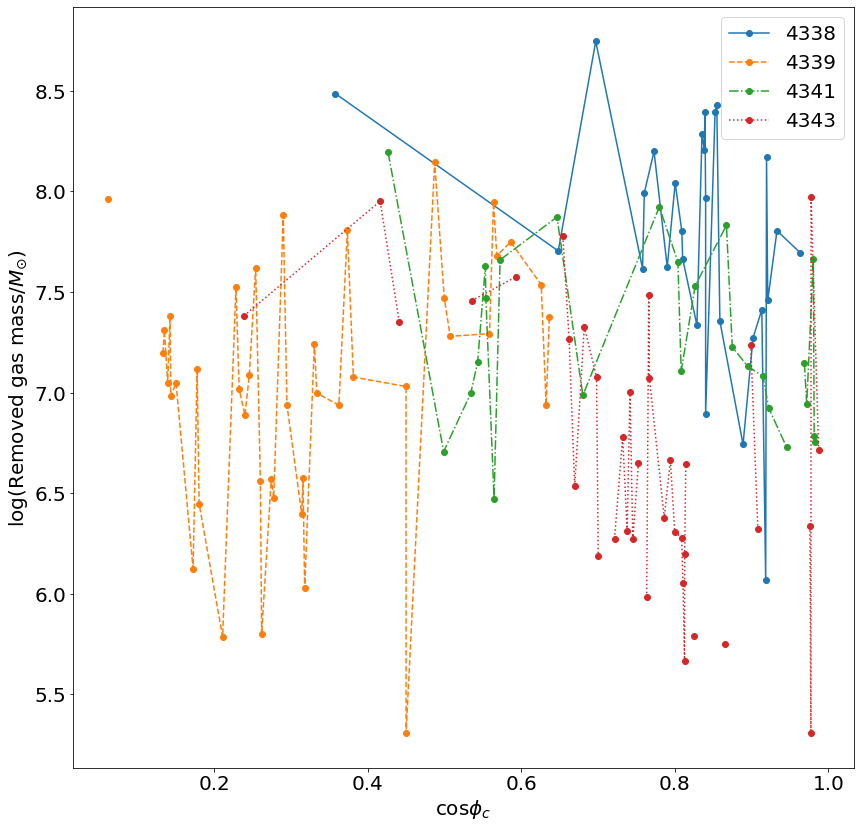

In [22]:
# ok, now that i have it lets see, first without any smoothering

pl.figure(figsize=(14,14))

ii_4338 = np.argsort(np.abs(cosC_4338))
ii_4339 = np.argsort(np.abs(cosC_4339))
ii_4341 = np.argsort(np.abs(cosC_4341))
ii_4343 = np.argsort(np.abs(cosC_4343))

pl.plot(np.abs(cosC_4338[ii_4338]), np.log10(Gas_4338[ii_4338]), label='4338', marker='o',ls='-')
pl.plot(np.abs(cosC_4339[ii_4339]), np.log10(Gas_4339[ii_4339]), label='4339', marker='o',ls='--')
pl.plot(np.abs(cosC_4341[ii_4341]), np.log10(Gas_4341[ii_4341]), label='4341', marker='o',ls='-.')
pl.plot(np.abs(cosC_4343[ii_4343]), np.log10(Gas_4343[ii_4343]), label='4343', marker='o',ls=':')

pl.legend(loc='best')

pl.xlabel('$\cos \phi_c$')
pl.ylabel('$\log($Removed gas mass$/M_{\odot})$')

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()


Text(0, 0.5, '$\\log($Removed gas mass$/M_{\\odot})$')

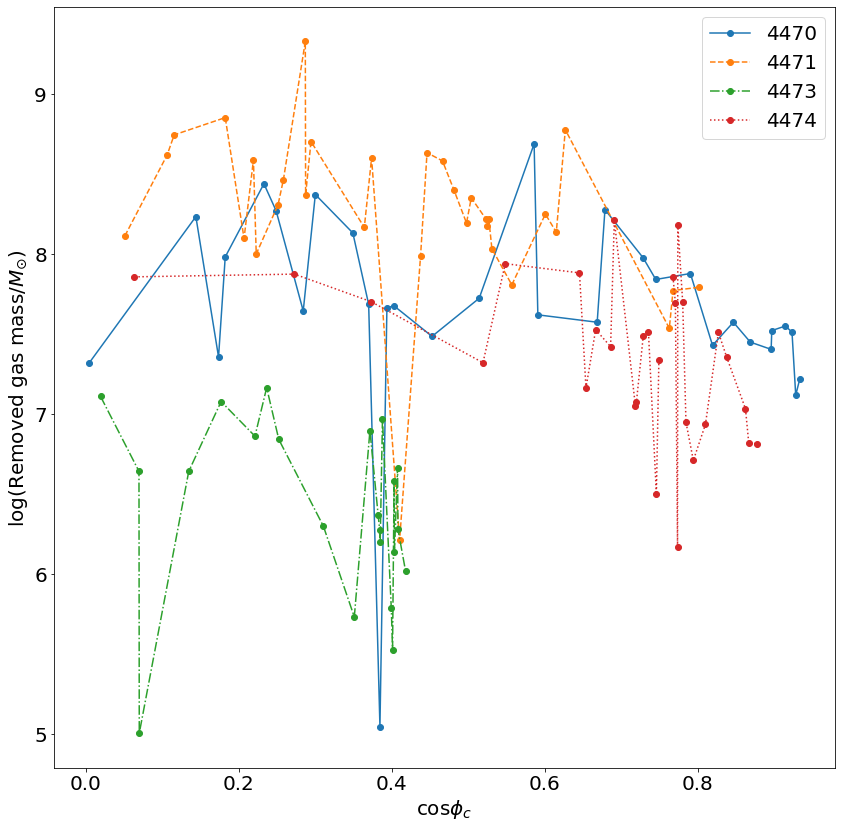

In [23]:
pl.figure(figsize=(14,14))

ii_4470 = np.argsort(np.abs(cosC_4470))
ii_4471 = np.argsort(np.abs(cosC_4471))
ii_4473 = np.argsort(np.abs(cosC_4473))
ii_4474 = np.argsort(np.abs(cosC_4474))

pl.plot(np.abs(cosC_4470[ii_4470]), np.log10(Gas_4470[ii_4470]), label='4470', marker='o',ls='-')
pl.plot(np.abs(cosC_4471[ii_4471]), np.log10(Gas_4471[ii_4471]), label='4471', marker='o',ls='--')
pl.plot(np.abs(cosC_4473[ii_4473]), np.log10(Gas_4473[ii_4473]), label='4473', marker='o',ls='-.')
pl.plot(np.abs(cosC_4474[ii_4474]), np.log10(Gas_4474[ii_4474]), label='4474', marker='o',ls=':')

pl.legend(loc='best')

pl.xlabel('$\cos \phi_c$')
pl.ylabel('$\log($Removed gas mass$/M_{\odot})$')

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()


Text(0, 0.5, '$\\log($Removed gas mass$/M_{\\odot})$')

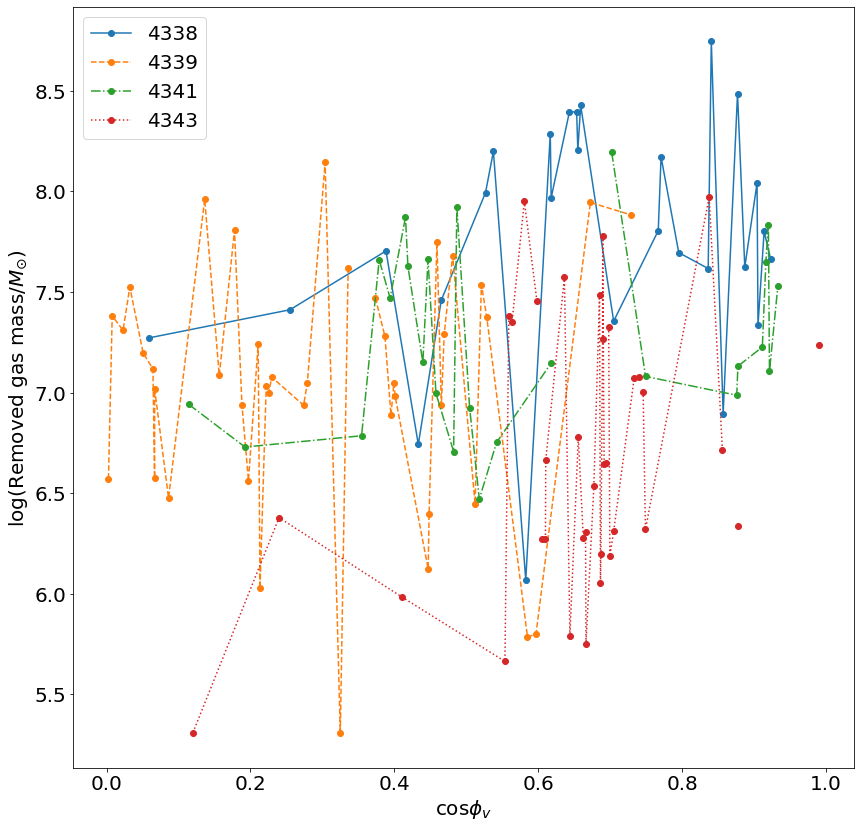

In [24]:
pl.figure(figsize=(14,14))

ii_4338 = np.argsort(np.abs(cosV_4338))
ii_4339 = np.argsort(np.abs(cosV_4339))
ii_4341 = np.argsort(np.abs(cosV_4341))
ii_4343 = np.argsort(np.abs(cosV_4343))

pl.plot(np.abs(cosV_4338[ii_4338]), np.log10(Gas_4338[ii_4338]), label='4338', marker='o',ls='-')
pl.plot(np.abs(cosV_4339[ii_4339]), np.log10(Gas_4339[ii_4339]), label='4339', marker='o',ls='--')
pl.plot(np.abs(cosV_4341[ii_4341]), np.log10(Gas_4341[ii_4341]), label='4341', marker='o',ls='-.')
pl.plot(np.abs(cosV_4343[ii_4343]), np.log10(Gas_4343[ii_4343]), label='4343', marker='o',ls=':')

pl.legend(loc='best')

pl.xlabel('$\cos \phi_v$')
pl.ylabel('$\log($Removed gas mass$/M_{\odot})$')

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()


Text(0, 0.5, '$\\log($Removed gas mass$/M_{\\odot})$')

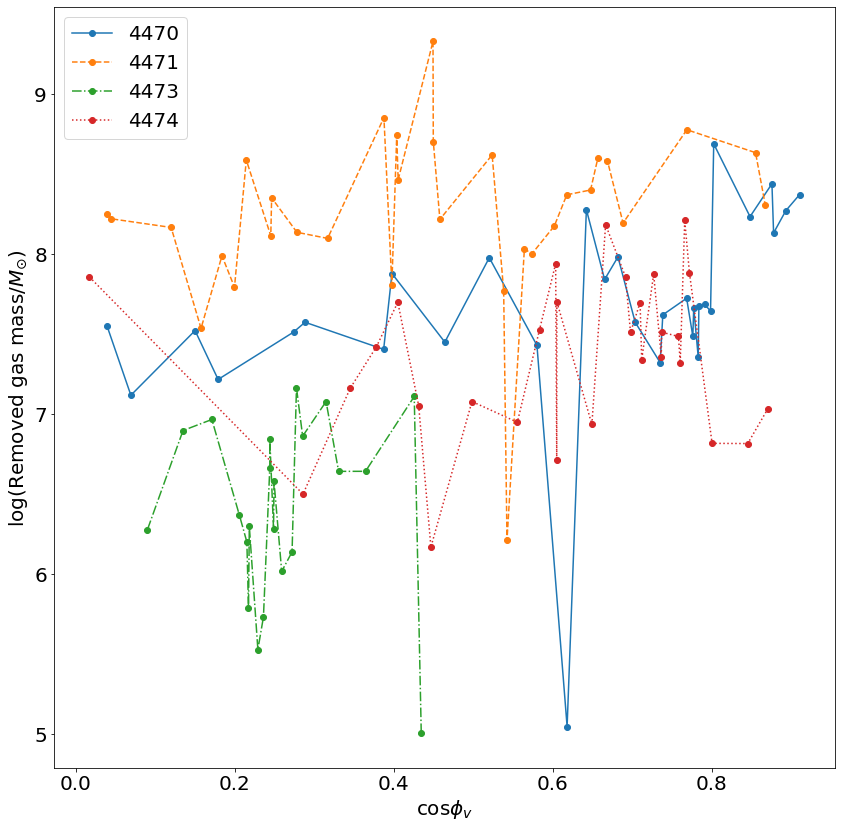

In [25]:
pl.figure(figsize=(14,14))

ii_4470 = np.argsort(np.abs(cosV_4470))
ii_4471 = np.argsort(np.abs(cosV_4471))
ii_4473 = np.argsort(np.abs(cosV_4473))
ii_4474 = np.argsort(np.abs(cosV_4474))

pl.plot(np.abs(cosV_4470[ii_4470]), np.log10(Gas_4470[ii_4470]), label='4470', marker='o',ls='-')
pl.plot(np.abs(cosV_4471[ii_4471]), np.log10(Gas_4471[ii_4471]), label='4471', marker='o',ls='--')
pl.plot(np.abs(cosV_4473[ii_4473]), np.log10(Gas_4473[ii_4473]), label='4473', marker='o',ls='-.')
pl.plot(np.abs(cosV_4474[ii_4474]), np.log10(Gas_4474[ii_4474]), label='4474', marker='o',ls=':')

pl.legend(loc='best')

pl.xlabel('$\cos \phi_v$')
pl.ylabel('$\log($Removed gas mass$/M_{\odot})$')

In [26]:
# that need jesus,i mean, smoothering.
def smoother(cosC, cosV, Gas, n):
    I = np.arange(cosC.size)
    
    newCosC, newCosV, newGas = np.zeros(I.size), np.zeros(I.size), np.zeros(I.size)
    for i in I:
        itemp = np.arange(i-n, i+n+1)
        itemp = itemp[np.where((itemp>=0) & (itemp<I[-1]))]
        tcosC = cosC[itemp]
        tcosV = cosV[itemp]
        tGas = Gas[itemp]
        
        tcosC = tcosC[np.where((np.isnan(tcosC)==False) & (np.isinf(tcosC)==False))]
        tcosV = tcosV[np.where((np.isnan(tcosV)==False) & (np.isinf(tcosV)==False))]
        tGas = tGas[np.where((np.isnan(tGas)==False) & (np.isinf(tGas)==False))]
        
        newCosC[i] = np.mean(tcosC)
        newCosV[i] = np.mean(tcosV)
        newGas[i] = np.mean(tGas)
        
    return newCosC, newCosV, newGas

In [27]:
n = 3

newCosC_4338, newCosV_4338, newGas_4338 = smoother(np.abs(cosC_4338), np.abs(cosV_4338), Gas_4338, n)
newCosC_4339, newCosV_4339, newGas_4339 = smoother(np.abs(cosC_4339), np.abs(cosV_4339), Gas_4339, n)
newCosC_4341, newCosV_4341, newGas_4341 = smoother(np.abs(cosC_4341), np.abs(cosV_4341), Gas_4341, n)
newCosC_4343, newCosV_4343, newGas_4343 = smoother(np.abs(cosC_4343), np.abs(cosV_4343), Gas_4343, n)

newCosC_4470, newCosV_4470, newGas_4470 = smoother(np.abs(cosC_4470), np.abs(cosV_4470), Gas_4470, n)
newCosC_4471, newCosV_4471, newGas_4471 = smoother(np.abs(cosC_4471), np.abs(cosV_4471), Gas_4471, n)
newCosC_4473, newCosV_4473, newGas_4473 = smoother(np.abs(cosC_4473), np.abs(cosV_4473), Gas_4473, n)
newCosC_4474, newCosV_4474, newGas_4474 = smoother(np.abs(cosC_4474), np.abs(cosV_4474), Gas_4474, n)

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in log10


Text(0, 0.5, '$\\log($Removed gas mass$/M_{\\odot})$')

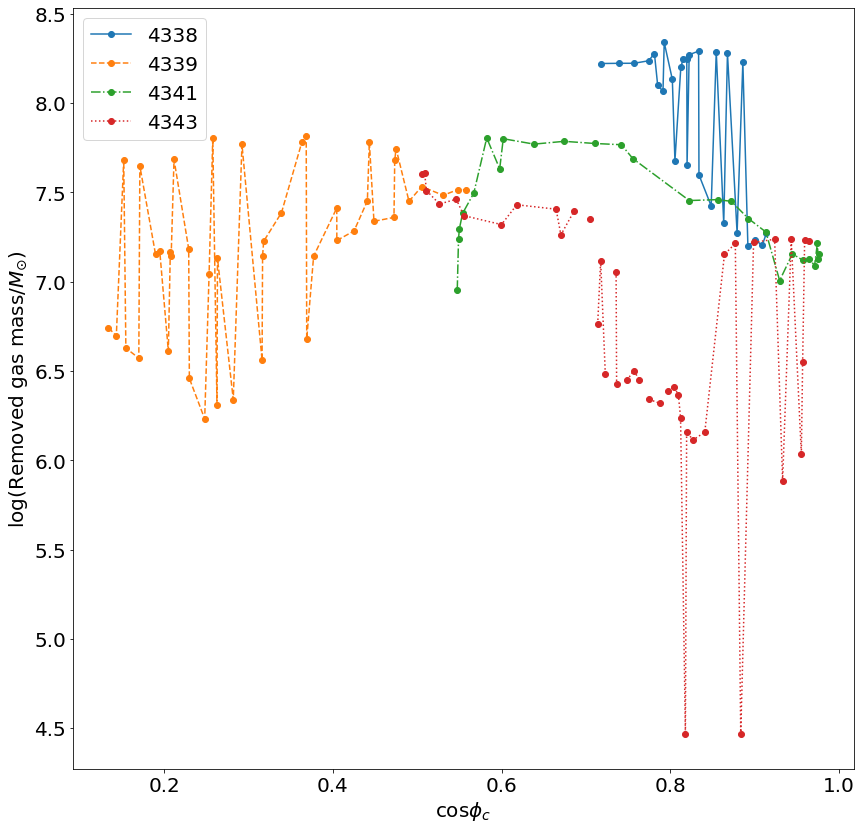

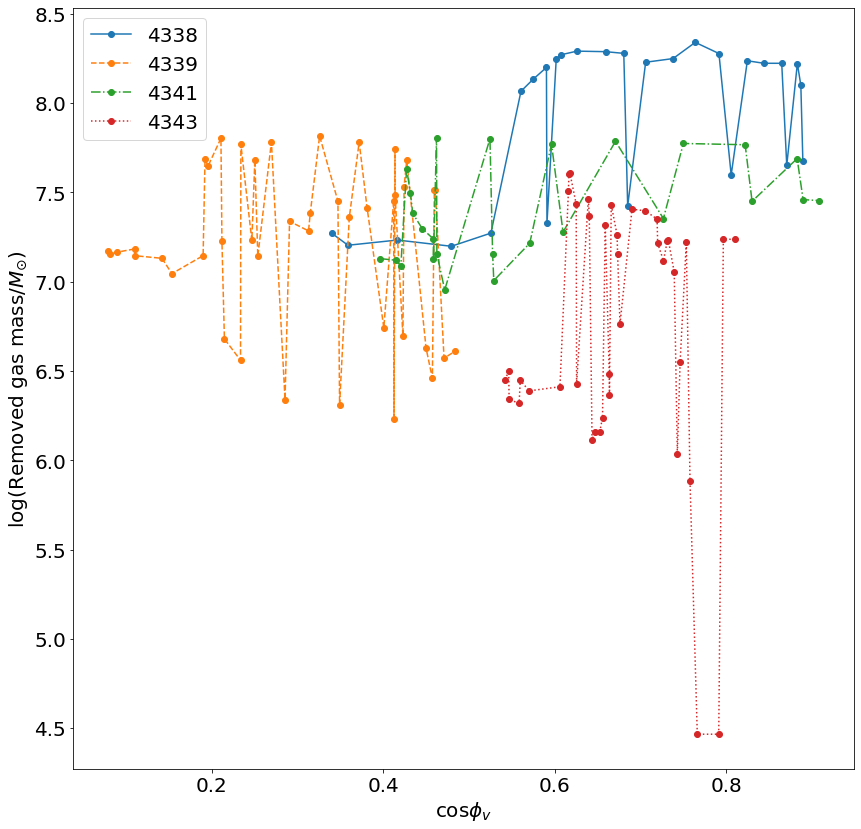

In [28]:
pl.figure(figsize=(14,14))

ii_4338 = np.argsort(newCosC_4338)
ii_4339 = np.argsort(newCosC_4339)
ii_4341 = np.argsort(newCosC_4341)
ii_4343 = np.argsort(newCosC_4343)

pl.plot(newCosC_4338[ii_4338], np.log10(newGas_4338[ii_4338]), label='4338', marker='o',ls='-')
pl.plot(newCosC_4339[ii_4339], np.log10(newGas_4339[ii_4339]), label='4339', marker='o',ls='--')
pl.plot(newCosC_4341[ii_4341], np.log10(newGas_4341[ii_4341]), label='4341', marker='o',ls='-.')
pl.plot(newCosC_4343[ii_4343], np.log10(newGas_4343[ii_4343]), label='4343', marker='o',ls=':')

pl.legend(loc='best')

pl.xlabel('$\cos \phi_c$')
pl.ylabel('$\log($Removed gas mass$/M_{\odot})$')

pl.figure(figsize=(14,14))

ii_4338 = np.argsort(newCosV_4338)
ii_4339 = np.argsort(newCosV_4339)
ii_4341 = np.argsort(newCosV_4341)
ii_4343 = np.argsort(newCosV_4343)

pl.plot(newCosV_4338[ii_4338], np.log10(newGas_4338[ii_4338]), label='4338', marker='o',ls='-')
pl.plot(newCosV_4339[ii_4339], np.log10(newGas_4339[ii_4339]), label='4339', marker='o',ls='--')
pl.plot(newCosV_4341[ii_4341], np.log10(newGas_4341[ii_4341]), label='4341', marker='o',ls='-.')
pl.plot(newCosV_4343[ii_4343], np.log10(newGas_4343[ii_4343]), label='4343', marker='o',ls=':')

pl.legend(loc='best')

pl.xlabel('$\cos \phi_v$')
pl.ylabel('$\log($Removed gas mass$/M_{\odot})$')

Text(0, 0.5, '$\\log($Removed gas mass$/M_{\\odot})$')

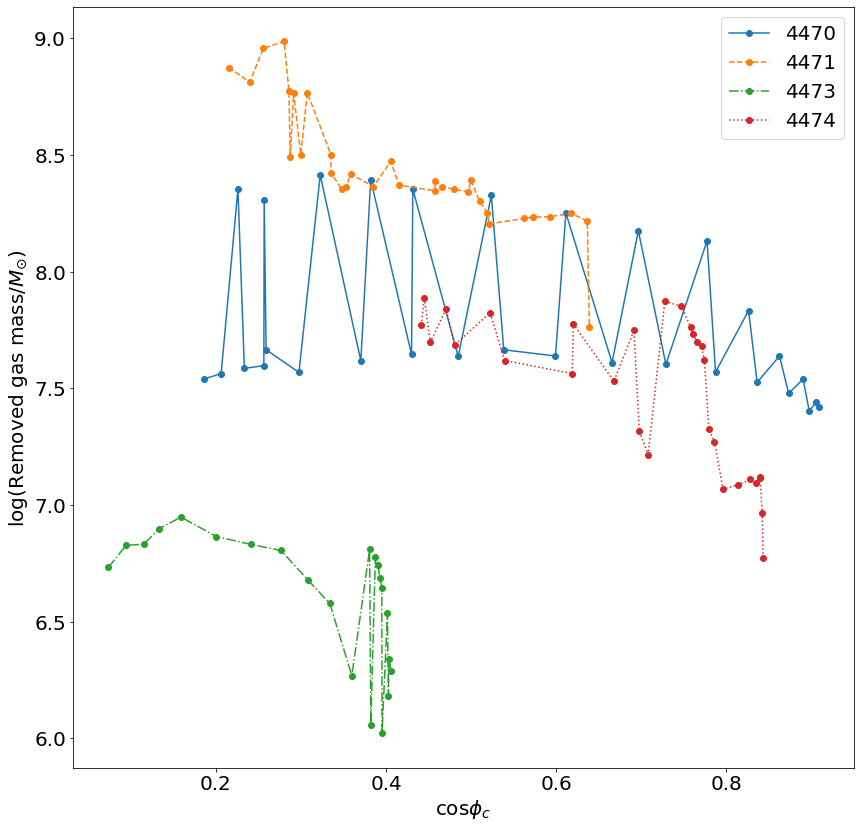

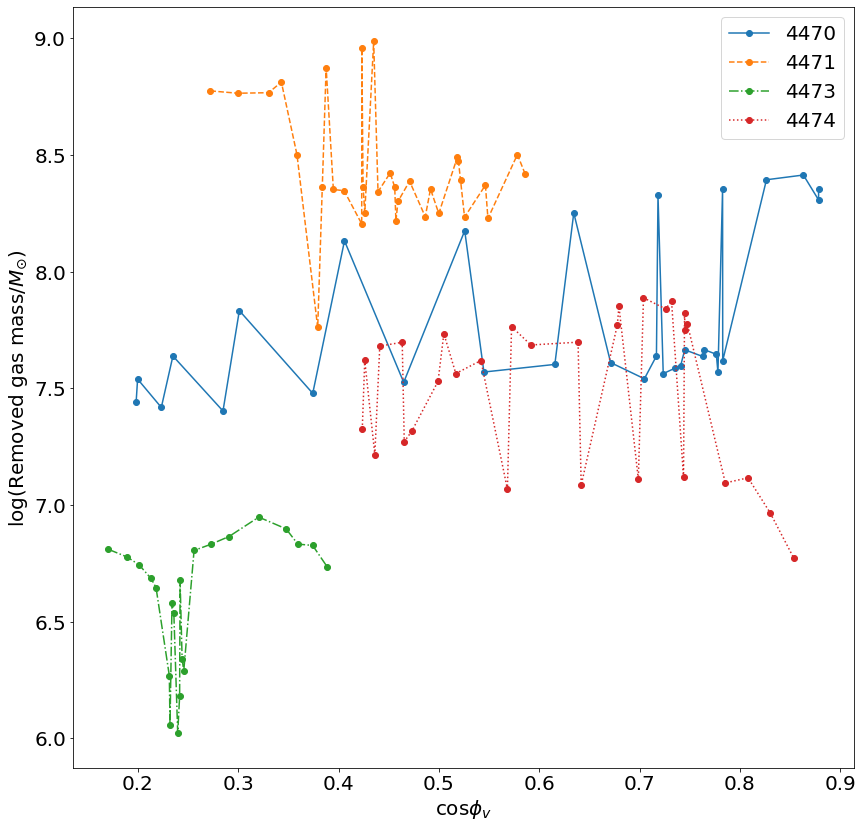

In [29]:
pl.figure(figsize=(14,14))

ii_4470 = np.argsort(newCosC_4470)
ii_4471 = np.argsort(newCosC_4471)
ii_4473 = np.argsort(newCosC_4473)
ii_4474 = np.argsort(newCosC_4474)

pl.plot(newCosC_4470[ii_4470], np.log10(newGas_4470[ii_4470]), label='4470', marker='o',ls='-')
pl.plot(newCosC_4471[ii_4471], np.log10(newGas_4471[ii_4471]), label='4471', marker='o',ls='--')
pl.plot(newCosC_4473[ii_4473], np.log10(newGas_4473[ii_4473]), label='4473', marker='o',ls='-.')
pl.plot(newCosC_4474[ii_4474], np.log10(newGas_4474[ii_4474]), label='4474', marker='o',ls=':')

pl.legend(loc='best')

pl.xlabel('$\cos \phi_c$')
pl.ylabel('$\log($Removed gas mass$/M_{\odot})$')

pl.figure(figsize=(14,14))

ii_4470 = np.argsort(newCosV_4470)
ii_4471 = np.argsort(newCosV_4471)
ii_4473 = np.argsort(newCosV_4473)
ii_4474 = np.argsort(newCosV_4474)

pl.plot(newCosV_4470[ii_4470], np.log10(newGas_4470[ii_4470]), label='4470', marker='o',ls='-')
pl.plot(newCosV_4471[ii_4471], np.log10(newGas_4471[ii_4471]), label='4471', marker='o',ls='--')
pl.plot(newCosV_4473[ii_4473], np.log10(newGas_4473[ii_4473]), label='4473', marker='o',ls='-.')
pl.plot(newCosV_4474[ii_4474], np.log10(newGas_4474[ii_4474]), label='4474', marker='o',ls=':')

pl.legend(loc='best')

pl.xlabel('$\cos \phi_v$')
pl.ylabel('$\log($Removed gas mass$/M_{\odot})$')